In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
np.random.seed(20)

In [3]:
from datetime import date
from matplotlib import pyplot as plt


In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, Model
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate


2023-12-28 14:01:14.964528: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-28 14:01:15.221273: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 14:01:15.221316: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 14:01:15.222808: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 14:01:15.347436: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-28 14:01:15.348435: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [5]:
import tensorflow as tf
tf.random.set_seed(20)

In [6]:
import matplotlib.pyplot as plt
import datetime as dt 
import urllib.request, json

In [7]:
df = pd.read_csv('Diesel.csv')
df

,Tanggal,qty,Jumlah
0,2016-01-01,836,5600932.0
1,2016-01-02,964,6460341.0
2,2016-01-03,1900,12727990.0
3,2016-01-04,1944,13023929.0
4,2016-01-05,7653,43238490.0
...,...,...,...
2083,2021-12-27,3892,20043800.0
2084,2021-12-28,3848,19817200.0
2085,2021-12-29,3915,20162250.0
2086,2021-12-30,2715,13982250.0


In [8]:
df.isnull().sum()

Tanggal    0
qty        0
Jumlah     0
dtype: int64

In [9]:
stockprices = df.sort_values('Tanggal')

In [10]:
def calculate_rmse(y_actual, y_predict):
    rmse = np.sqrt(np.mean((y_actual - y_predict)**2))
    return rmse

In [11]:
def calculate_mape(y_actual, y_predict):
    y_predict, y_actual = np.array(y_predict), np.array(y_actual)
    mape = np.mean(np.abs((y_actual - y_predict) / y_predict)) * 100
    return mape

In [12]:
def extract_seqX_outcomeY(data, N, offset_value):
    training_Sequence_X = []
    output_value_y = []

    for i in range(offset_value, len(data)):
        training_Sequence_X.append(data[i-N:i])
        output_value_y.append(data[i])

    return np.array(training_Sequence_X), np.array(output_value_y)

In [13]:
test_ratio = 0.2
training_ratio = 0.8

training_size = int(training_ratio * len(stockprices))
testing_size = int(test_ratio * len(stockprices))

print('training_size: ' + str(training_size))
print('testing_size: ' + str(testing_size))

train = stockprices[:1500][['Tanggal', 'Jumlah']]
test = stockprices[1500:][['Tanggal', 'Jumlah']]

print(train.shape)
print(test.shape)

training_size: 1670
testing_size: 417
(1500, 2)
(588, 2)


In [14]:
stockprices = stockprices.set_index('Tanggal')
stockprices

,qty,Jumlah
Tanggal,,
2016-01-01,836,5600932.0
2016-01-02,964,6460341.0
2016-01-03,1900,12727990.0
2016-01-04,1944,13023929.0
2016-01-05,7653,43238490.0
...,...,...
2021-12-27,3892,20043800.0
2021-12-28,3848,19817200.0
2021-12-29,3915,20162250.0


In [15]:
def plotting_stock_trend(var, current_title, stockprices=stockprices):
    ax = stockprices[['Jumlah','50 day']].plot(figsize = (16, 8))
    ax = stockprices[['Jumlah', var,]].plot(figsize = (16, 8))
    print(ax)
    plt.grid(False)
    plt.title(current_title)
    plt.axis('tight')
    plt.ylabel('Total', fontsize=16)

def calculate_perform_metrics(var):
    ### Root mean squared error
    rmse = calculate_rmse(np.array(stockprices[training_size:]['Jumlah']), np.array(stockprices[training_size:][var]))
    ### Mean absolute percentage error
    mape = calculate_mape(np.array(stockprices[training_size:]['Jumlah']), np.array(stockprices[training_size:][var]))

    return rmse, mape



In [16]:
window_size = 35

Axes(0.125,0.11;0.775x0.77)
RMSE: 7869796.403646355
MAPE %: 24.730355471014338


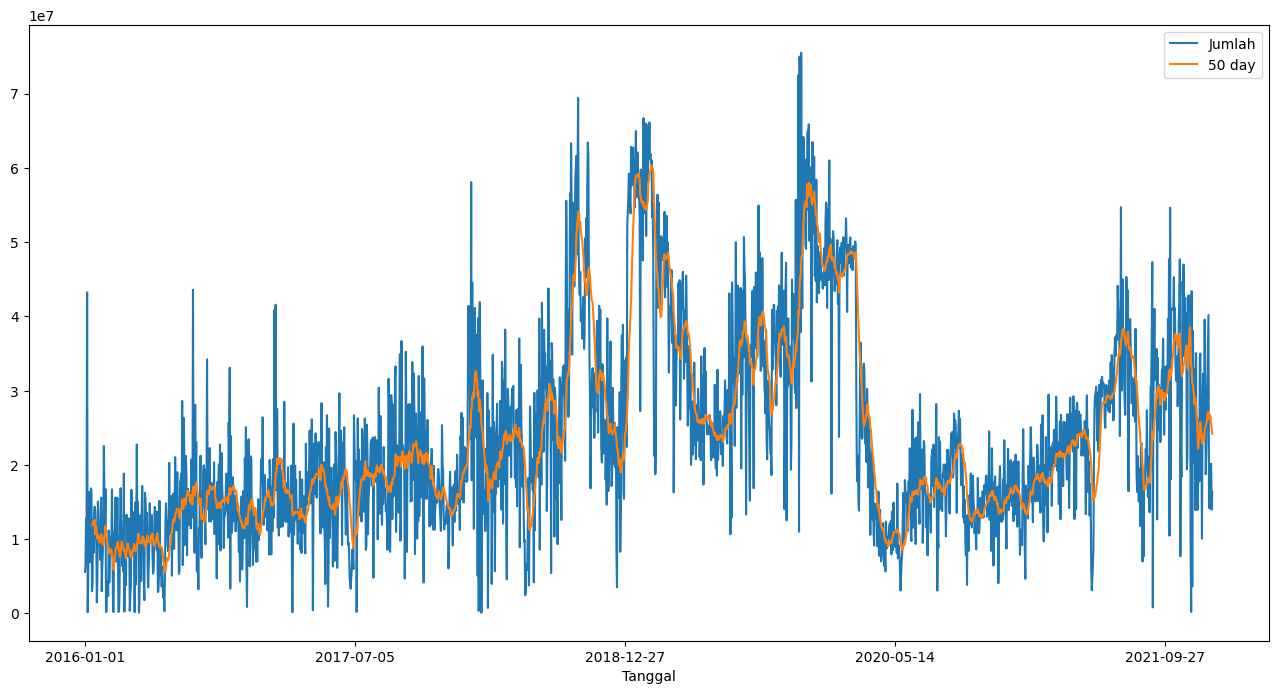

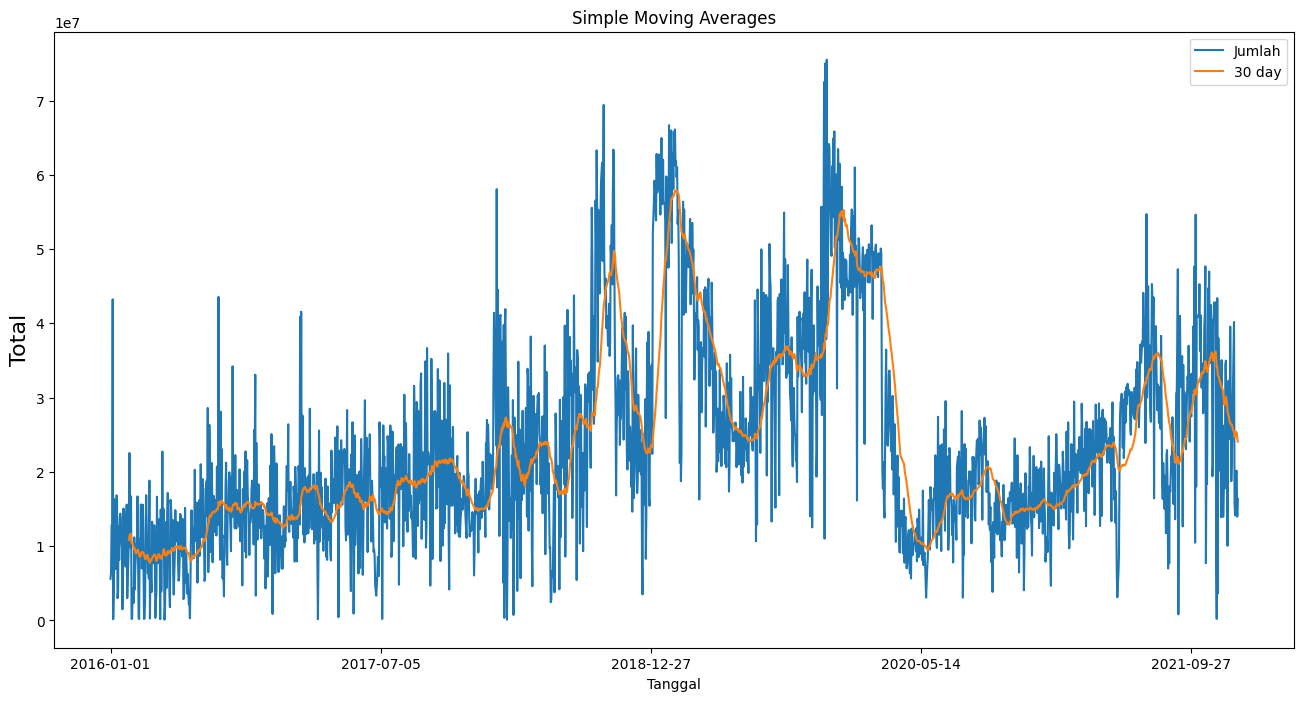

In [17]:
window_variable = str(30) + ' day' + ''
stockprices[window_variable] = stockprices['Jumlah'].rolling(window_size).mean()
### for reference, include 200 day simple moving average
stockprices['50 day'] = stockprices['Jumlah'].rolling(15).mean()

### plotting and performance metrics for simple moving average model
plotting_stock_trend(var = window_variable, current_title = 'Simple Moving Averages')
rmse_sma, mape_sma = calculate_perform_metrics(var=window_variable)
print('RMSE:', rmse_sma)
print('MAPE %:', mape_sma)

Axes(0.125,0.11;0.775x0.77)
RMSE: 7287869.864209112
MAPE %: 22.884218930309125


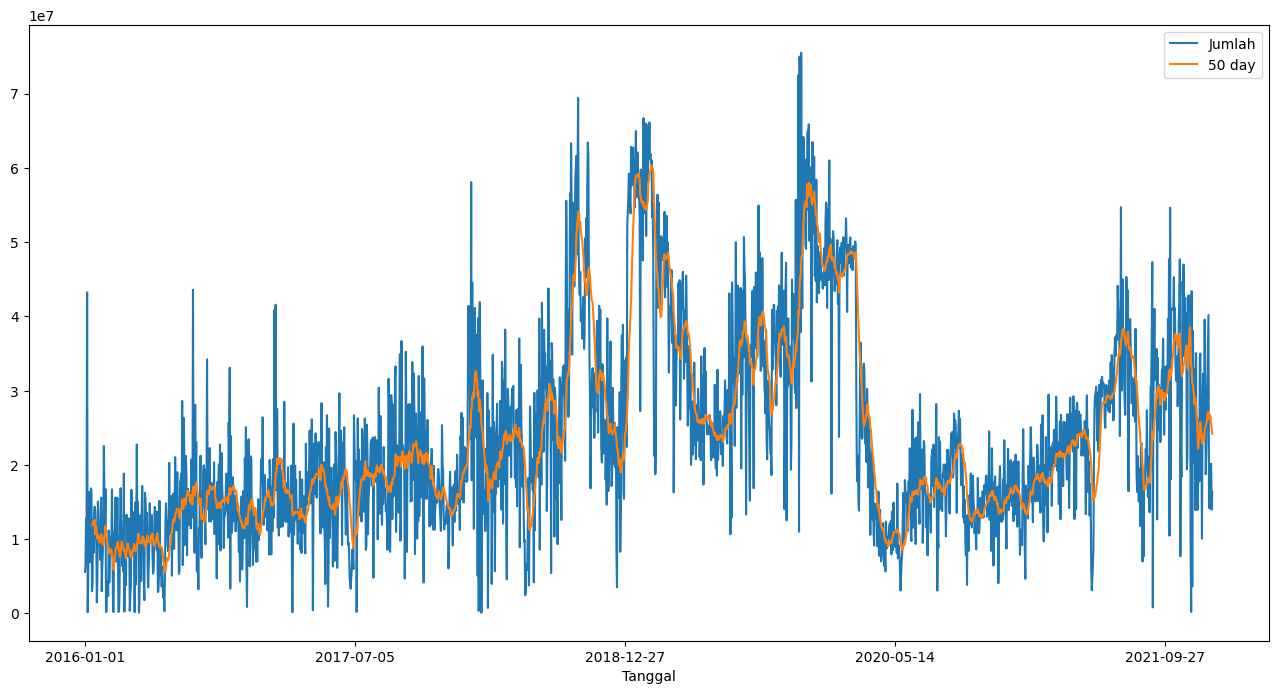

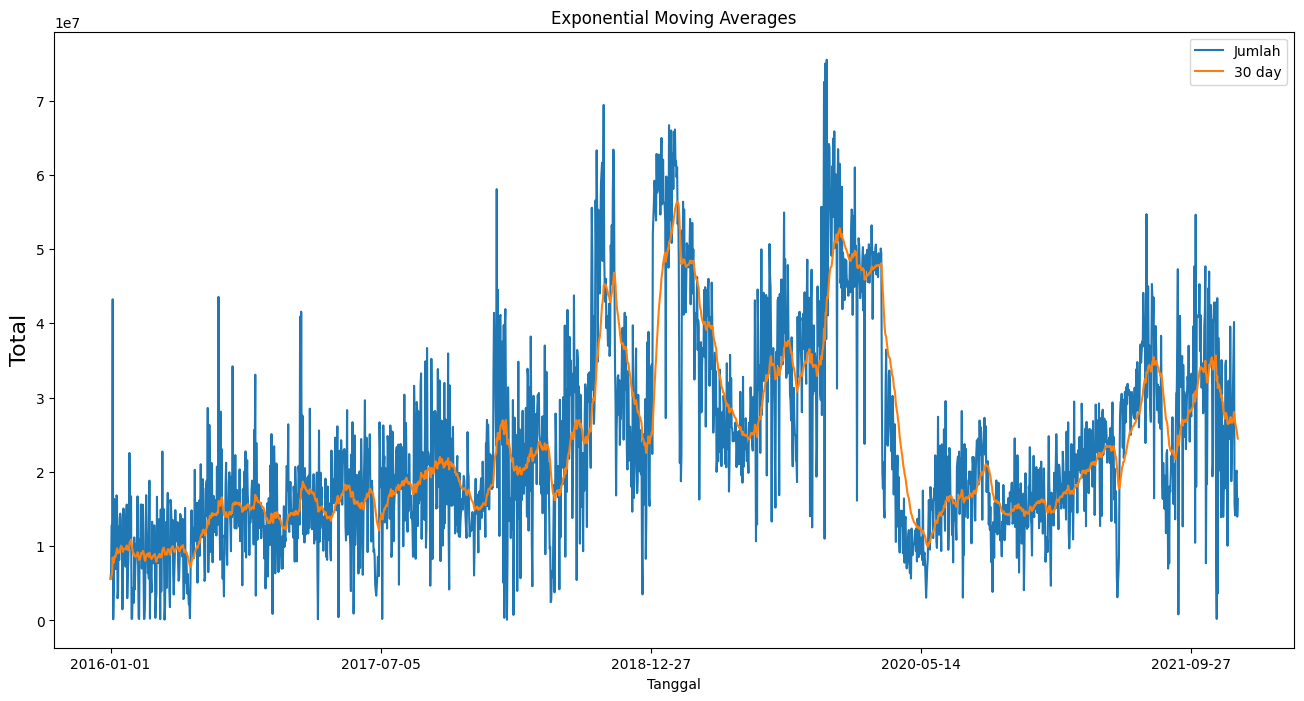

In [18]:
### Exponential MA
window_ema_variable = str(30) + ' day' 
# Calculate the exponentially weighted moving average for the Nth day
stockprices[window_ema_variable] = stockprices['Jumlah'].ewm(span = window_size, adjust = False).mean()
stockprices['50day'] = stockprices['Jumlah'].rolling(30).mean()

### plotting and performance metrics for exponential moving average model
plotting_stock_trend(var = window_ema_variable, current_title = 'Exponential Moving Averages')
rmse_ema, mape_ema = calculate_perform_metrics(var = window_ema_variable)
print('RMSE:', rmse_ema)
print('MAPE %:', mape_ema)